# Logistic Regression

## Data import

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

from tqdm.notebook import tqdm
from math import sqrt
from random import seed
from random import randrange
from math import pi
from math import exp

In [35]:
# read data
data = pd.read_csv('creditcard.csv')


## Data Division

In [36]:
# remove 'Class' column
dataset_to_be_normalized = data.iloc[:,:-1]

# compute the mean 
data_mean = dataset_to_be_normalized.mean()
# compute the standard deviation
data_std = dataset_to_be_normalized.std()
# normalize the data
data_normalized = (dataset_to_be_normalized - data_mean) / data_std

# append 'Class' column
data_normalized['Class'] = data.iloc[:,-1]

Divide in training and test set 

In [37]:
# convert data to numpy 2D array
data_normalized_np = data_normalized.to_numpy()

# shuffle data
np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(data_normalized_np) 
fraction_validation = 0.3

# divide into training_set and test_set
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))

train_set = data_normalized_np[:num_train,:]
valid_set = data_normalized_np[num_train:,:]

train_set.shape, valid_set.shape

((144240, 31), (61818, 31))

Divide the training set in subsets with specific ratios

In [38]:
fraud = train_set[train_set[:,-1] == 1]
non_fraud = train_set[train_set[:,-1] == 0]

np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(non_fraud) 

# ratio 50:50
new_non_fraud = non_fraud[:fraud.shape[0],:]

# concatenate the two matrix
train_set1 = np.r_[new_non_fraud,fraud]

np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(non_fraud) 

# ratio 34:64
new_non_fraud = non_fraud[:int(fraud.shape[0] * (66/34)),:]

# concatenate the two matrix
train_set2 = np.r_[new_non_fraud,fraud]

np.random.seed(0) # set seed to 0 for reproducibility
np.random.shuffle(non_fraud) 

# ratio 25:75
new_non_fraud = non_fraud[:int(fraud.shape[0] * (75/25)),:]

# concatenate the two matrix
train_set3 = np.r_[new_non_fraud,fraud]

train_set1.shape, train_set2.shape, train_set3.shape

((520, 31), (764, 31), (1040, 31))

In [77]:
x1 = train_set1[:,:-1]
y1 = train_set1[:,-1]

x1.shape,y1.shape

((520, 30), (520,))

In [78]:
x2 = train_set2[:,:-1]
y2 = train_set2[:,-1]

x2.shape,y2.shape

((764, 30), (764,))

In [79]:
x3 = train_set3[:,:-1]
y3 = train_set3[:,-1]

x3.shape,y3.shape

((1040, 30), (1040,))

In [80]:
xValid = valid_set[:,:-1]
yValid = valid_set[:,-1]

xValid.shape, yValid.shape

((61818, 30), (61818,))

## Define functions 

In [42]:
def initialize_params(weight_size):
  """
  The purpose of this function is to initialize the weights and bias

  @params: weight_size: number of features 
  @return: array of dimention (weights_size + 1) initialize to zero 
  """
  return np.zeros(weight_size) 

In [43]:
def sigmoid(z):
  """
  This function returns the value of the sigmoid function given an input value

  @params: z: a linear combination of the input and the features associated with the training examples
  """
  return (1/(1+jnp.exp(-z)))

In [158]:
def loss(x,y,params):
  # phi = sigmoid(x1 @ params)
  # logical = (y1 == (1-(phi)))
  return - jnp.mean(jnp.log( y*(sigmoid(x @ params)) + (1-y)*(1-sigmoid(x @ params))))

  0%|          | 0/500 [00:00<?, ?it/s]

train loss: 3.313e-01


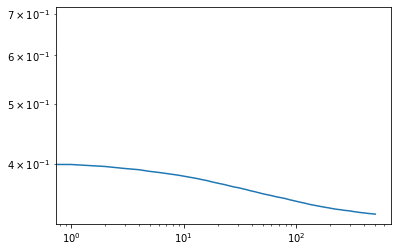

In [159]:
from jax._src.numpy.lax_numpy import gradient
# hyperparameters
num_epochs = 500
learning_rate_min = 5e-2
learning_rate_max = 1e-1
learning_rate_decay = 2000
batch_size = 500
num_train = x1.shape[0]
# setup
params = initialize_params(x1.shape[1])

grad_jit = jax.jit(jax.grad(loss, argnums=2))
loss_jit = jax.jit(loss)

train_history = [loss_jit(x1, y1, params)]

# training loop
t0 = time.time()
for epoch in tqdm(range(num_epochs)):
  learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
  minibatch = np.random.choice(num_train, batch_size)
  gradients = grad_jit(x1[minibatch,:], y1[minibatch], params) 
  for i in range(len(params)):
    params[i] -= learning_rate * gradients[i]
 
  train_history.append(loss_jit(x1, y1, params))

print('train loss: %1.3e' % train_history[-1])
plt.loglog(train_history, label = 'train loss')

In [160]:
def predicted(x,params):
  phi = sigmoid(x @ params)
  pred = list()
  for i in range(phi.shape[0]):
    pred.append(1 if phi[i] >= 0.5 else 0)
                
  return pred 

In [161]:
pred = predicted(xValid,params)

In [162]:
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(xValid)):
  if(yValid[i] == 1) and (pred[i]==1):
    TP += 1
  if(yValid[i] == 0) and (pred[i]==0):
    TN += 1
  if(yValid[i] == 0) and (pred[i]==1):
    FP += 1
  if(yValid[i] == 1) and (pred[i]==0):
    FN += 1

In [163]:
print("TP %d " % TP)
print("TN %d " % TN)
print("FP %d " % FP)
print("FN %d " % FN)

TP 130 
TN 34643 
FP 27042 
FN 3 


In [54]:
def accuracy(TP,TN,FP,FN):
  return (TP + TN) / (TP + FP + TN + FN)

In [55]:
def sensitivity(TP,FN):
  return TP/(TP+FN)

In [56]:
def specificity(TN,FP):
  return TN/(FP+TN)

In [57]:
def precision(TP,FP):
  return TP/(TP+FP)

In [58]:
def F_measure(precision,sensitivity):
  return (2 * ((precision * sensitivity)/(precision + sensitivity)))

In [59]:
def AUC(sensitivity, specificity):
  return (0.5 * (sensitivity + specificity))

In [164]:
acc = accuracy(TP,TN,FP,FN)
sens = sensitivity(TP,FN)
spec = specificity(TN,FP)
prec = precision(TP,FP)
f = F_measure(prec,sens)
auc = AUC(sens, spec)

  
print('Accurancy   ' + '{:.1%}'.format(acc))
print('Sensitivity ' + '{:.1%}'.format(sens))
print('Specificity ' + '{:.1%}'.format(spec))
print('Precision   ' + '{:.1%}'.format(prec))
print('F_measure   ' + '{:.1%}'.format(f))
print('AUC         ' + '{:.1%}'.format(auc) + '\n')

Accurancy   56.3%
Sensitivity 97.7%
Specificity 56.2%
Precision   0.5%
F_measure   1.0%
AUC         77.0%

